In [1]:
def in_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [2]:
tf_cpu_debugging =False
if tf_cpu_debugging:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    import tensorflow as tf
    #tf.debugging.set_log_device_placement(True)
    a = tf.constant(1)
    
    if tf.test.gpu_device_name():
        print("GPUs recognized by tensorflow:", tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found")

tf_gpu_debugging = False
if tf_gpu_debugging:
    import os 
    os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'
    import tensorflow as tf
    tf.debugging.set_log_device_placement(True)
    a = tf.constant(1)
    
    if tf.test.gpu_device_name():
        print("GPUs recognized by tensorflow:", tf.config.list_physical_devices('GPU'))
    else:
        print("No GPU found")

In [3]:
if in_notebook():
    !ulimit -s unlimited
else:
    print("Be sure ulimit -s is set to unlimited!")
        

main miniGAP notebook

In [4]:
import sys
sys.path.append('../code')
from Molecular_Dynamics import generate_md_traj, make_diatomic
from miniGAP_helper_functions import PrepareDataForTraining, self_energy, GatherStructureInfo, GenerateDescriptorsAndDerivatives, SparsifySoaps

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import gpflow
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfk = tfp.math.psd_kernels
from gpflow.kernels import SquaredExponential, Polynomial
from itertools import islice
from  tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
from ase.io import read
import pandas as pd
from gpflow.utilities import print_summary
if in_notebook():
    gpflow.config.set_default_summary_fmt("notebook")
else:
    gpflow.config.set_default_summary_fmt("grid")

In [5]:
print("{} GPU(s) recognized by tensorflow:".format(len(tf.config.list_physical_devices('GPU'))), tf.config.list_physical_devices('GPU'))

1 GPU(s) recognized by tensorflow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
# some basic helper functions
import time

def PrintNoScientificNotation(*x):
    np.set_printoptions(suppress=True) # Do not print in scientific notation
    print(*x)
    np.set_printoptions(suppress=False)
       
def TickTock(func, *args, **kwargs):
    tick = time.time()
    func_output = func(*args, **kwargs)
    tock = time.time()
    return func_output, tock - tick

In [7]:
# These plotting settings make graphs easier to read
# This is a very clunky way to do this so I want to move this soon, but haven't had much of a chance

SMALL_SIZE = 11
MEDIUM_SIZE = 13
BIG_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title

---

# Current Training (As of 11/17)
### Broken into a bunch of steps with comments

---

## Prep work

In [8]:

if not in_notebook():
    import argparse
    
    # --------------------------------------------  commandline argument code   -----------------------------------------------------------------------
    parser = argparse.ArgumentParser()

#     parser.add_argument('--verbose', action='store_true', help="Print out details at each step") 

    #parser.add_argument('-t', '--time', action='store_true', help="Option to time tasks")

    parser.add_argument('-sf', '--structure_file',  help="Specify a structure file to import. If none given and -md used, will generate diatomics.")

    parser.add_argument("-md", '--molecular_dynamics', action='store_true', help="Indicate if you want molecular dynamics performed. Will generate diatomic if no structure given")
#     parser.add_argument('-mdi', '--md_indices', default=[0], type=int, nargs='*', help="If performing molecular dynamics on a structure file with multiple structures, you can give indices of all structures to perform md on.")

    #structure_source = parser.add_mutually_exclusive_group(required=True)
    #structure_source.add_argument('-gd', '--generate_diatomics', action='store_true', help="Option to generate a MD trajectory of diatomic molecules")
    #structure_source.add_argument('-is', '--import_structure', help="Specify a structure file to import")

    parser.add_argument('-n', '--n_structs',  type=int, help="Specify # of diatomic molecules or # of structures to use from input file")

    # arguments specific to generating diatomics
    parser.add_argument('-el', '--element',  choices = ["N", "O", "H"], help="If generating diatomics, specify element")
    parser.add_argument('--temp',  type=float, help="If generating diatomics, specify temperatutre (K) of MD")
    parser.add_argument('-mds', '--md_seed',  type=int, help="If generating diatomics, change this seed to get different trajectories")
    parser.add_argument('-ec', '--energy_calculator',  choices = ["EMT", "LJ", "Morse"], help = "If generating diatomics, specify ASE energy/force calculator")

    # arguments specific to soap
    parser.add_argument('--rcut',  type=float, help= "Choice of SOAP cut off radius")
    parser.add_argument('--nmax',  type=int, help="Choice of SOAP n_max")
    parser.add_argument('--lmax',  type=int, help="Choice of SOAP l_max")

    # arguments specific to learning
    parser.add_argument('-ss', '--split_seed', type=int, help="Random seed for cross-validation")
    parser.add_argument('-tf', '--train_fraction', type=float, help="Specify the fraction of structures used in training")
    parser.add_argument('-ne', '--n_epochs', type=int, help="Number of epochs")

    # some housekeeping
#     parser.add_argument('remainder', nargs=argparse.REMAINDER, help=argparse.SUPPRESS)

    cmdline_args = parser.parse_args()
    cmdline_args_dict = vars(cmdline_args)


Loaded 200 structures into FullStructureList


In [10]:
# Input parameter important notes:

# energy_encoding=#"info" for QM9 or "normal" for distorted propenols
# energy_keyword="U0" for QM9 or ignored for distorted propenols

# my_priority = #"efficiency" for experimenting with something new or otherwise "consistency"

# # controls initial train_test_split breaking apart training and test data
# split_seed = 2

# # controls in-training train_test_split breaking apart training_j and validation_j data
# valid_split_seed = 2

# # controls multiple tf stochastic processes including:
# # 1) Adams optimizer AND 
# # 2) batching through tf.data.Dataset.from_tensor_slices in training
# tf_seed = 2

# # controls batching through tf.data.Dataset.from_tensor_slices in training
# shuffle_seed = 2

# kernel_type = #"polynomial" for actual GAP or "exponentiated_quadratic" possibly for debugging

# prediction_calculation = #"direct" OR "predict_f" OR "cholesky" OR "alpha"

# Complete this on 11/24 morning  

1. What I need to still do today is just convert reference to direct names to references to the s. names  
2. Implement that structure filename choice from commandline

In [11]:
import json
from collections import namedtuple

settings_json_filename = "../code/miniGAP_settings.json"
with open(settings_json_filename, encoding = 'utf-8') as settings_file_object:
    default_settings_dict = json.load(settings_file_object)

settings_dict = default_settings_dict
if not in_notebook():
    for setting_name in settings_dict.keys():
        if setting_name in cmdline_args_dict.keys():
            if cmdline_args_dict[setting_name] != None:
                settings_dict[setting_name] = cmdline_args_dict[setting_name]
SettingsNamespace = namedtuple("Settings", settings_dict.keys())
s = SettingsNamespace(*settings_dict.values())

In [ ]:
if in_notebok():
    FullStructureList = read("../data/distorted_propanol.extxyz.gz", ":200")#, ":{}".format(s.n_structs))
    # FullStructureList = read("../data/C7O2H10.extxyz.gz",            ":")
    print("Loaded {} structures into FullStructureList".format(len(FullStructureList)))

Pick which structures to train

In [12]:
# Diatomic molecule with evenly spaced bond lengths
# StructureList = [make_diatomic(element = s.element, verbose=False, bond_length=L, calc_type=s.energy_calculator) for L in np.linspace(.6,1.8, s.n_structs)]

# Diatomic molecule in MD trajectory
# StructureList = generate_md_traj(from_diatomic=True, preoptimize=False, bond_length=1.5, element=s.element, temperature=s.temp, nsteps=s.n_structs, md_type = "VelocityVerlet", calc_type=s.energy_calculator, md_seed= s.md_seed, time_step=.6)

# ethanol molecule in MD trajectory
# from ase.build import molecule
# StructureList = generate_md_traj(from_diatomic=False, structure=molecule("CH3CH2OH"), temperature=s.temp, nsteps=s.n_structs, md_type = "VelocityVerlet", calc_type=s.energy_calculator, md_seed= s.md_seed, time_step=.05)

print("s.n_structs =",  s.n_structs)
# 2000 distorted propanols (librascal structures)
#   Forces included
#StructureList = read("../data/distorted_propanol.extxyz.gz", ":{}".format(s.n_structs))
StructureList = FullStructureList[::len(FullStructureList)//s.n_structs][:s.n_structs]

# 10000 graphenes from Alvaro
#   Forces included
# StructureList = read("../data/ManyGraphenes.gz", ":{}".format(s.n_structs))

# 6095 isomers of C7O2H10 (subset of QM9)
#   No forces
# StructureList = read("../data/C7O2H10.extxyz.gz", ":{}".format(s.n_structs))
# StructureList = FullStructureList[::len(FullStructureList)//s.n_structs][:s.n_structs]

print("Using {} structures.".format(len(StructureList)))

ns_atoms = np.unique([len(struct) for struct in StructureList])
assert len(ns_atoms) == 1
n_atoms = ns_atoms[0]

Using 200 structures.


In [13]:
check_structures_visually = False
if check_structures_visually:
    from Visualize_Structures import Structure3DAnimation, Structure3DPlot
    html_animation = Structure3DAnimation(StructureList, azimuth=0, elevation=90).Plot()
    display(html_animation)

Parse data from dataset

In [14]:
EnergyList, ForceList, PosList = GatherStructureInfo(StructureList,gather_forces = s.use_forces, use_self_energies=s.use_self_energies, 
                                                     energy_encoding = s.energy_encoding,  energy_keyword = s.energy_keyword)

Generate SOAP descriptors

In [15]:
[SoapDerivativeList, SoapList], TimeSoap = TickTock(GenerateDescriptorsAndDerivatives, StructureList, s.nmax, s.lmax, s.rcut, s.smear, s.attach_SOAP_center, s.is_periodic, s.use_forces)
print(TimeSoap)

0.0702824592590332


---

## Now the training starts

Preparing the energies, forces, soap descriptors and derivatives into a format usable for tensorflow training

---

1. Split all data into training and test sets.  
Test sets will not be viewed until training is done  
2. Scale soaps and energies separately to have zero mean and unit variance.  
Divide the derivatives by the same scale factor but don't subtract the mean
3. Convert data to tensorflow tensors where necessary  

In [16]:
out_data, TimePrepare = TickTock(PrepareDataForTraining, 
                                sp_list=SoapList, 
                                dsp_dx_list = SoapDerivativeList, 
                                en_list = EnergyList,
                                frc_list = ForceList ,
                                pos_list = PosList, 
                                split_seed = s.split_seed, 
                                prepare_forces = s.use_forces, 
                                train_fract = s.train_fraction,
                                scale_soaps = s.scale_soaps
                                )

print(TimePrepare)

if not s.use_forces:
    train_sps_full, test_sps_full, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var = out_data
else:
    train_sps_full, test_sps_full, train_ens, test_ens, train_indices, test_indices, soap_scaler, ens_scaler, ens_var, train_dsp_dx, test_dsp_dx, train_frcs, test_frcs, frcs_var = out_data 


0.018133878707885742


In [17]:
TimeBeforeSparsification = time.time()     
SparsifySoapsOutput = SparsifySoaps(train_soaps = train_sps_full, test_soaps = test_sps_full, train_energies=train_ens, sparsify_samples=s.sparse_gpflow, 
                                    n_samples=s.n_sparse, sparsify_features=s.sparse_features, n_features=s.n_sparse_features, selection_method="PCovCUR",
                                    score_tolerance=1e-5, score_threshold=1e-5, iterative_selection=False) 
train_sps, sparse_train_sps, test_sps = SparsifySoapsOutput
TimeAfterSparsification = time.time()

print("Sparsification time = ", TimeAfterSparsification - TimeBeforeSparsification)


Sparsification time =  0.0001652240753173828


In [18]:
plot_importances = False
if plot_importances and s.sparse_gpflow:
#     feature_scores = feature_selector._compute_pi(train_sps_full, train_ens)
    feature_scores = feature_selector.score(train_sps)
#     sample_scores = sample_selector._compute_pi(train_sps_full, train_ens)
    sample_scores = sample_selector.score(train_sps)

    fig, axs = plt.subplots(ncols = 2, figsize=(12, 5))

    axs[0].plot(np.sort(feature_scores)[::-1])
    axs[0].set_ylabel("Feature Scores")
    axs[1].plot(np.sort(sample_scores)[::-1] )
    axs[1].set_ylabel("Sample Scores")
    for ax in axs:
        ax.set_ylim(bottom=0)

Reshape energies, soaps, etc so that local data can be separated

Scale soaps and energies separately to have zero mean and unit variance.

Divide the derivatives by the same scale factor but don't subtract the mean

Convert data to tensorflow tensors where necessary

Define a few things used in training loop

* loss/error function
* optimizer

In [19]:
# Note: I still need to add the Tikhonov regularization term for loss to make the mse equivalent to negative log likelihood

@tf.function(autograph=False, experimental_compile=False)
def mse(y_predict, y_true):
    return tf.math.reduce_mean(tf.math.squared_difference(y_predict, y_true))

@tf.function(autograph=False, experimental_compile=False)
def mse_2factor(y1_predict, y1_true, weight1, y2_predict, y2_true, weight2):
    mse1 = mse(y1_predict, y1_true)
    mse2 = mse(y2_predict, y2_true)*3

    return mse1 * weight1 + mse2 * weight2

#@tf.function(autograph=False, experimental_compile=False)
def train_step_without_forces_full(model, valid_soap, valid_energy): #, optimizer):
    with tf.GradientTape() as tape:
        predict_energy = model.predict_f(valid_soap)[0]
        tf.print("predict energies = ", predict_energy[:3])
        my_mse = mse(predict_energy, valid_energy)
    gradients = tape.gradient(my_mse, model.trainable_variables)
    tf.print("gradients = ", gradients)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    print("TRACING train_step_without_forces_full")
    return my_mse

@tf.function(autograph=False, experimental_compile=False)
def predict_energies_from_weights(c, soaps_old, soaps_new, degree):
    k = tf.math.pow( tf.tensordot(soaps_old, tf.transpose(soaps_new), axes=1), degree )
    return tf.linalg.matmul(c, k, transpose_a=True)

### Possible improvements to my GPflow training
---
1. Use Adam optimizer
2. Custom loss function vs optimizer.minimize
3. Don't use constrain_positive
4. Set certain variable untrainable

Perform training loop

GPFlow test with many data points

In [20]:
# Initialize kernels and model hyperparameters
verbose = True
tf.random.set_seed(s.tf_seed)

TimeBeforePreEpoch = time.time()


train_step_without_forces_full_tf = tf.function(train_step_without_forces_full)

noise_init = 1e-4 #.001# 0.0005499093576274776 #1.625e-4
obs_noise = tf.Variable(noise_init, dtype=s.dtype, name="noise")

if s.kernel_type == "exponentiated_quadratic":
    amp_init = 2
    
    # The following line tries to control for the size and natural spread of the data
    len_init = 1#0.1*train_sps.shape[-1]/np.mean(soap_scaler.scale_ )
    amplitude = tf.Variable(initial_value=amp_init, dtype=s.dtype)
    len_scale = tf.Variable(initial_value=len_init,  dtype=s.dtype)
    kernel = SquaredExponential(variance=amplitude, lengthscales=len_scale, name="exponentiated_quadratic_kernel_gpf")
elif s.kernel_type == "polynomial":
    slope_init = 1 #600#1#1e-2#1e-8#0.0004530304664784989
    slope = tf.Variable(slope_init, dtype=s.dtype, name="kernel_amplitude")
    offset_init = np.finfo(np.float64).tiny# 1e-24#1e-10
    offset = tf.constant(offset_init, dtype=s.dtype, name="offset")
    degree_init = 2
    degree = tf.constant(degree_init, dtype=s.dtype, name="degree")
    print("Raising linear kernel to degree {} creating a polynomial kernel. The training is broken for degree =/= 1 unless we use predict_f".format(degree_init))
    kernel = Polynomial(variance=slope, offset=offset, degree=degree)
else:
    print("Warning: Do not recognize kernel_type={}".format(s.kernel_type))

    


# Split training data into training and validation sets
# Now validation set acts as temporary est set
# train_test_split and tensorflow tensors don't get along so I temporarily convert them back to numpy arrays

train_indices_j, valid_indices_j  = train_test_split(np.arange(len(train_sps)), random_state = s.valid_split_seed, test_size=(1-s.valid_fract))

train_sps_j, valid_sps_j = train_sps[train_indices_j], train_sps[valid_indices_j]
train_ens_j, valid_ens_j = train_ens[train_indices_j], train_ens[valid_indices_j]

if s.use_forces: 
    train_dsp_dx_j, valid_dsp_dx_j = train_dsp_dx[train_indices_j], train_dsp_dx[valid_indices_j]
    train_frcs_j, valid_frcs_j = train_frcs[train_indices_j], train_frcs[valid_indices_j]

# Convert to tensorflow constant tensors
train_sps_j = tf.constant(train_sps_j, dtype=s.dtype)
train_ens_j = tf.constant(train_ens_j, dtype=s.dtype)
valid_sps_j = tf.constant(valid_sps_j, dtype=s.dtype)
valid_ens_j = tf.constant(valid_ens_j, dtype=s.dtype)
if s.sparse_gpflow:
    sparse_train_sps = tf.Variable(sparse_train_sps, shape=sparse_train_sps.shape, dtype=s.dtype, trainable=False)

if s.use_forces:
    train_dsp_dx_j = tf.constant(train_dsp_dx_j, dtype=s.dtype)
    train_frcs_j = tf.constant(train_frcs_j, dtype=s.dtype)    
    valid_dsp_dx_j = tf.constant(valid_dsp_dx_j, dtype=s.dtype)
    valid_frcs_j = tf.constant(valid_frcs_j, dtype=s.dtype)        

test_sps = tf.constant(test_sps, dtype=s.dtype)


# Batch data if  training set is larger than batch_size_max
if len(train_sps_j) < s.batch_size_max:
    iterations_per_epoch = 1
    batch_size = len(train_sps_j)
    if verbose:
        print("Training using {} atoms without batching.".format(len(train_sps_j)))
else:
    iterations_per_epoch = int(np.ceil(len(train_sps_j)/s.batch_size_max))
    batch_size = int(np.ceil(len(train_sps_j)/iterations_per_epoch))
    if verbose:
        print("Training using {} atoms total using {} batches with {} atoms per batch.".format( len(train_sps_j), iterations_per_epoch, batch_size ))

# training(out_data)
        
TimeBeforeEpoch0 = time.time()


mse_history = []    
hyperparam_history = []



# import warnings
# 
# from gpflow.models import VGP, GPR, SGPR, SVGP
# from gpflow.optimizers import NaturalGradient
# from gpflow.optimizers.natgrad import XiSqrtMeanVar
# from gpflow import set_trainable


if s.my_priority == "efficiency":
    # I don't know what this does
    autotune = tf.data.experimental.AUTOTUNE
    
    
    batches = (
        tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j))
        .prefetch(autotune) 
        .shuffle(buffer_size=len(train_sps_j), seed=s.shuffle_seed)
        .repeat(count=None)
        .batch(batch_size)
    )
    
    batch_iterator = iter(batches)

    # I also don't know why we use this
    from gpflow.ci_utils import ci_niter, ci_range
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=s.learn_rate)
    
else:
    batches = (
        tf.data.Dataset.from_tensor_slices((train_sps_j, train_ens_j)) 
        .shuffle(buffer_size=len(train_sps_j), seed=s.shuffle_seed) 
        .repeat(count=None)
        .batch(batch_size)
    )    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=s.learn_rate)
    #optimizer = tf.keras.optimizers.SGD(learning_rate=s.learn_rate)
    


# new code to make tf.function training work
# --------------------------------------------
train_sps_j_i = tf.Variable(train_sps[:batch_size], shape=(batch_size, train_sps.shape[-1]), dtype=s.dtype, trainable=False )
train_ens_j_i = tf.Variable(train_ens[:batch_size], shape=(batch_size, 1), dtype=s.dtype, trainable=False ) 
if s.sparse_gpflow:
    if len(sparse_train_sps) >= batch_size:
        print("Warning: Batch size is not greater than sparse soap size.\nThis may cause errors in the predict_f function which assumes the inducing points to be fewer than the data points.")
    if s.my_priority == "efficiency":
        gpr_model = gpflow.models.SVGP( kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(),  inducing_variable=sparse_train_sps)
        gpr_model.likelihood.variance.assign(obs_noise)
        gpflow.set_trainable(gpr_model.q_mu, False)
        gpflow.set_trainable(gpr_model.q_sqrt, False)
    else:
        gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise, inducing_variable=sparse_train_sps)
else:
    if s.my_priority == "efficiency":
        # it seems I cannot use  noise_variance=obs_noise for this which makes it not GAP...
        gpr_model = gpflow.models.VGP( data=(train_sps_j_i, train_ens_j_i), kernel=kernel, likelihood=gpflow.likelihoods.Gaussian())
    else:
        gpr_model = gpflow.models.GPR( data=(train_sps_j_i, train_ens_j_i), kernel=kernel, noise_variance=obs_noise)
# --------------------------------------------


print_frequency = max(s.min_print_frequency, int(s.n_epochs/10))

if s.my_priority == "efficiency":
    hyperparam_history.append([(0, np.exp(var.numpy() )) for var in gpr_model.trainable_variables])  
    gpr_objective = gpr_model.training_loss_closure(batch_iterator,  compile=True)
    for j in range(ci_niter(s.n_epochs)):
        if not j % print_frequency:
            print("Epoch {}".format(j))
        optimizer.minimize(gpr_objective, var_list=gpr_model.trainable_variables)
        mse_history.append((j+1, gpr_model.elbo(data=(train_sps, train_ens))))
        hyperparam_history.append([(j+1, np.exp(var.numpy()) ) for var in gpr_model.trainable_variables]) 
    #optimizer.minimize(gpr_model.training_loss, gpr_model.trainable_variables, options=dict(maxiter=s.n_epochs))
        
elif s.my_priority == "consistency":

    hyperparam_history.append([(0, var.numpy()) for var in gpr_model.trainable_parameters])  
    for j in range(s.n_epochs):
        if not j % print_frequency:
            print("Epoch {}".format(j))
            #print(" ".join(["{} = {:.2e} ".format(var.name, np.exp(var.numpy())) for var in trainable_variables]))

        mse_ens_j = 0
        for i, (train_sps_j_i, train_ens_j_i) in enumerate(islice(batches, iterations_per_epoch)):
            if not s.use_forces: #and not s.sparse_gpflow :
                gpr_model.data[0].assign(train_sps_j_i)
                gpr_model.data[1].assign(train_ens_j_i)        
                mse_ens_j_i = train_step_without_forces_full_tf(gpr_model, valid_sps_j, valid_ens_j)
                print("valid_ens[:3] = {}".format( valid_ens_j[:3].numpy().flatten()) )
#                 print(mse_ens_j_i.numpy(), valid_ens_j[:3].numpy().flatten(), train_ens_j_i[:3].numpy().flatten()  )


            else:
                print("Using normal approach")
                with tf.GradientTape() as tape:
                    with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
                        tape_sps.watch(valid_sps_j)
        #                 gprm_j_i = tfd.GaussianProcessRegressionModel(
        #                     kernel = kernel,
        #                     index_points = valid_sps_j,
        #                     observation_index_points = train_sps_j_i,
        #                     observations = train_ens_j_i, #tf.constant(train_ens_j_i.numpy().flatten(), dtype=s.dtype),#train_ens_j_i,
        #                     observation_noise_variance = obs_noise)
        #                 predict_ens_j_i = gprm_j_i.mean()
                        if s.sparse_gpflow:
                            gpr_model = gpflow.models.SGPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel, inducing_variable=sparse_train_sps)
    #                         gpflow.set_trainable(gpr_model.inducing_variable, False)
                            if i < 3:
                                print_summary(gpr_model)            
                        else:
                            gpr_model.data[0].assign(train_sps_j_i)
                            gpr_model.data[1].assign(train_ens_j_i)
                            #gpr_model = gpflow.models.GPR(data=(train_sps_j_i, train_ens_j_i), kernel=kernel)
                        #gpr_model.likelihood.variance.assign(obs_noise)                
                        predict_ens_j_i = gpr_model.predict_f(valid_sps_j)[0]



        #                 gpr_model = gpflow.models.GPR(data=(sps_j_i, train_ens_j_i), kernel=kernel_gpf)
        #                 gpr_model.likelihood.variance.assign(obs_noise_gpf)
        #                 predict_ens_j_i_gpf = gpr_model.predict_f(valid_sps_j)

                    if s.use_forces:
                        predict_d_ens_j_i = tape_sps.gradient(predict_ens_j_i, valid_sps_j)
                        # In the following line I needed to include '* n_atoms' after breaking energies into local energies
                        # The reason is that I am effectively breaking the connection between E and F when doing that
                        # F = -dE/dx =/= -dE_local/dx where E_local = E/n_atoms - E_free
                        # When I split energies into local energies I initially calculated -dE_local/dx which is -dE/dx / n_atoms
                        # This fix is prone to breaking the code and is not robust to systems with different structure size
                        # Need to improve this with a better fix
                        predict_frcs_j_i = -1*np.einsum('ijk,ik->ij', valid_dsp_dx_j, predict_d_ens_j_i) * n_atoms
                        mse_j_i = mse_2factor(predict_ens_j_i, valid_ens_j, 1/ens_var,
                                                predict_frcs_j_i, valid_frcs_j, 1/frcs_var)
                        mse_ens_j_i = mse(predict_ens_j_i, valid_ens_j)
                    else:
                        mse_j_i = mse(predict_ens_j_i, valid_ens_j)
                        mse_ens_j_i = mse_j_i


        #         grads = tape.gradient(mse_j_i, trainable_variables)
        #         optimizer.apply_gradients(zip(grads, trainable_variables))
                grads = tape.gradient(mse_j_i, gpr_model.trainable_variables)
                # print(gpr_model.trainable_variables[0])#grads[0])
                optimizer.apply_gradients(zip(grads, gpr_model.trainable_variables))
                if i < 3:
                    print_summary(gpr_model)

                if not gpr_model.data[0][0,0].numpy() == train_sps_j_i[0,0].numpy() :
                    print("ERRORERRORERRORERRORERRORERRORERROR")

            print("Adding mse_ens_j_i to mse_ens_j: {} + {} = {} ".format(mse_ens_j_i.numpy(), mse_ens_j , mse_ens_j_i.numpy() + mse_ens_j  ))
            mse_ens_j += mse_ens_j_i

        mse_ens_j /= iterations_per_epoch
        print("Epoch {},  mse = {}".format(j, mse_ens_j))
        mse_history.append((j+1, mse_ens_j))
        hyperparam_history.append([(j+1, var.numpy()) for var in gpr_model.trainable_parameters])    

    

else:
    print("{} is not a reconized value for my_priority.\n Training did not occur.".format(s.my_priority))

print_summary(gpr_model)

TimeBeforeWeights = time.time()
print("Calculating weights")

if s.my_priority == "efficiency" and s.sparse_gpflow == True:
    gpr_model =gpr_model
elif s.my_priority == "consistency":
    if s.sparse_gpflow:
        gpr_model = gpflow.models.SGPR(data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance, inducing_variable  = sparse_train_sps)
    else:
        gpr_model = gpflow.models.GPR( data=(train_sps, train_ens), kernel=kernel, noise_variance = gpr_model.likelihood.variance)      

if s.sparse_gpflow:
    if s.prediction_calculation in ("direct", "cholesky"):
        print("Alert: {} prediction approach not implemented for sparse model. Using alpha approach instead.".format(s.prediction_calculation))
        trained_weights = gpr_model.posterior().alpha
    elif s.prediction_calculation == "alpha":
        trained_weights = gpr_model.posterior().alpha
else:
    if s.prediction_calculation in ("direct", "cholesky"):
        KNN = gpr_model.kernel(train_sps)
        KNN_diag = tf.linalg.diag_part(KNN)
        variance_diag = tf.fill(tf.shape(KNN_diag), gpr_model.likelihood.variance)
        KNN_plus_variance = tf.linalg.set_diag(KNN, KNN_diag + variance_diag)
        if s.prediction_calculation == "direct":
            KNN_inv =  tf.linalg.inv(KNN_plus_variance)
            trained_weights = tf.matmul(KNN_inv, train_ens)
        else:
            LNN = tf.linalg.cholesky(KNN_plus_variance)
            LNN_inv = tf.linalg.inv(LNN)
            KNN_inv_from_L = tf.matmul(LNN_inv, LNN_inv,transpose_a=True)
            trained_weights = tf.matmul(KNN_inv_from_L, train_ens)
    elif s.prediction_calculation == "alpha":
        print("ERROR: alpha not implemented for gpflow GPR. Skipping prediction")
    
TimeAfterTraining = time.time()


with tf.GradientTape(watch_accessed_variables=False) as tape_sps:
    tape_sps.watch(test_sps)  
    print("Predicting final energies")
    if s.prediction_calculation == "predict_f":
        predict_ens, predict_ens_var = gpr_model.predict_f(test_sps)
    else:
        if s.sparse_gpflow:
            predict_ens = tf.reshape( predict_energies_from_weights(trained_weights, sparse_train_sps, test_sps, degree), [-1,1])
        else:
            predict_ens = tf.reshape( predict_energies_from_weights(trained_weights,        train_sps, test_sps, degree), [-1,1])

test_ens_rescaled = ens_scaler.inverse_transform(test_ens)
predict_ens_rescaled = ens_scaler.inverse_transform(predict_ens)
if s.prediction_calculation == "predict_f":
    predict_ens_var_rescaled =  np.array(predict_ens_var * ens_scaler.scale_ **2)
    
if s.use_forces:
    print("Predicting final forces")    
    predict_d_ens = tape_sps.gradient(predict_ens, test_sps)
    predict_frcs = -1*np.einsum('ijk,ik->ij', test_dsp_dx, predict_d_ens) * n_atoms

    test_frcs_rescaled = test_frcs * ens_scaler.scale_
    predict_frcs_rescaled = predict_frcs * ens_scaler.scale_

TimeAfterPrediction = time.time()




Raising linear kernel to degree 2 creating a polynomial kernel. The training is broken for degree =/= 1 unless we use predict_f
Training using 1620 atoms without batching.


2021-11-24 09:46:44.433017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-24 09:46:44.970224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9686 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:01:00.0, compute capability: 7.0
2021-11-24 09:46:45.123582: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.offset,Parameter,Softplus,,True,(),float64,2.2250738585072626e-308
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00010000000000000011
GPR.data[0],ResourceVariable,,,False,"(1620, 390)",float64,"[[-1.24413767, -1.18190928, -0.7666605..."
GPR.data[1],ResourceVariable,,,False,"(1620, 1)",float64,[[2.45236228...


Calculating weights
Predicting final energies
Acknowledge direct


2021-11-24 09:46:45.538504: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x55b4eadd5b90


In [22]:
TrainingCellNonEpochsTraining = TimeBeforeEpoch0 - TimeBeforePreEpoch + TimeAfterTraining - TimeBeforeWeights 
if s.n_epochs:
    TimePerEpoch = (TimeBeforeWeights - TimeBeforeEpoch0)/s.n_epochs
else:
    TimePerEpoch = "N/A"
PredictionTime = TimeAfterPrediction - TimeAfterTraining

print("{:50s}: {:.3f}".format("Training time outside of epochs in training cell", TrainingCellNonEpochsTraining))
if s.n_epochs:
    print("{:50s}: {:.3f}".format( "Training time per epoch", TimePerEpoch))
print("{:50s}: {:.3f}".format("Prediction time", PredictionTime) )



Training time outside of epochs in training cell  : 1.153
Prediction time                                   : 0.075


In [23]:
if 'mse_history_by_n' not in locals():
    mse_history_by_n = {}
if 'hyperparam_history_by_n' not in locals():
    hyperparam_history_by_n = {}
    
hyperparam_history_by_n[s.n_structs] = hyperparam_history
mse_history_by_n[s.n_structs] = mse_history

print("Stored the hyperparameters and mse values for plotting under n={}".format(s.n_structs) )

Stored the hyperparameters and mse values for plotting under n=200


Plot results

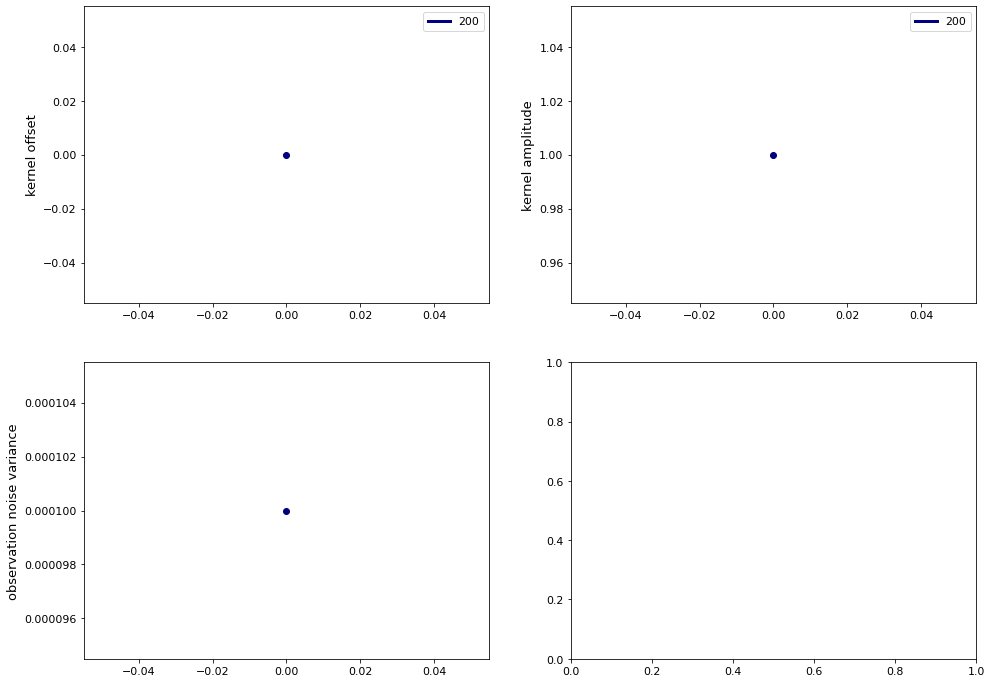

In [24]:

palette = plt.get_cmap('gist_ncar')#'nipy_spectral')#"viridis")
palette_size = palette.N#len(palette.colors)
palette_itr = 0

fig, [[ax00, ax01], [ax10, ax11]] = plt.subplots(nrows=2, ncols = 2, figsize=(16,12))

hyperparam_names = ["kernel offset", "kernel amplitude", "observation noise variance"]

for n in np.sort(list(mse_history_by_n.keys())):
    mse_history = mse_history_by_n[n]
    hyperparam_history = hyperparam_history_by_n[n]
    if not len(hyperparam_history):
        continue
    color = palette(palette_itr)
    palette_itr = (palette_itr + 30) % palette_size
    

    
    # hyperparameters on axes 00, 01, 10
    hyperparams = np.swapaxes(hyperparam_history, 0, 1)

    ax00.plot(*zip(*hyperparams[0]), color=color, label="{}".format(n), lw=3)
    ax00.plot(*hyperparams[0][-1], "o", color=color)
    label00 = hyperparam_names[0]
    ax00.set_ylabel("{}".format(label00))
#     #ax00.set_yscale('log')
#     annotation00 = ax00.annotate('{:.1f}'.format(amplitudes[-1][1]) , xy=amplitudes[-1], xycoords='data', xytext=(-30,100),
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
    ax00.legend()
    ax00.ticklabel_format(useOffset=False)

    ax01.plot(*zip(*hyperparams[1]), color=color, label="{}".format(n), lw=3)
    ax01.plot(*hyperparams[1][-1], "o", color=color)
    label01 = hyperparam_names[1]
    ax01.set_ylabel("{}".format(label01))
#     #ax01.set_yscale('log')
#     annotation01 = ax01.annotate('{:.1f}'.format(lengths[-1][1]) , xy=lengths[-1], xycoords='data', xytext=(100,-30), 
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
    ax01.legend()
    ax01.ticklabel_format(useOffset=False)

    ax10.plot(*zip(*hyperparams[-1]), color=color, label="{}".format(n), lw=3)
    ax10.plot(*hyperparams[-1][-1], "o", color=color)
    label10 = hyperparam_names[-1]
    ax10.set_ylabel("{}".format(label10))
    #ax10.set_yscale('log')
#     annotation01 = ax10.annotate('{:.1e}'.format(noises[-1][1]) , xy=noises[-1], xycoords='data', xytext=(-30,100),
#                                  textcoords='offset points', bbox={'fc':"1"}, arrowprops={'fc':'k'}, zorder=2)
#     ax10.legend()
    ax10.ticklabel_format(useOffset=False)
    
    if not len(mse_history):
        continue
    
    #loss on axis 11
    ax11.plot(*zip(*mse_history), color = color, label="{}".format(n), lw=3)
    ax11.plot(*mse_history[-1], "o", color=color)
    #ax11.set_yscale('log')
    bottom, top = ax11.get_ylim()
    bottom2, top2 = ax11.get_ylim()
    ax11.set_ylabel("mse")
    ax11.legend()
    ax11.ticklabel_format(useOffset=False)

    #fig.suptitle("{}".format(s.n_structs))

In [25]:
def plot_errors(global_ens, predicted_global_ens, model_description = "model", 
                use_local=False, local_ens=[], predicted_local_ens=[],
                color="mediumseagreen", predicted_stdev=None, n_atoms=10):
   
    global_ens, predicted_global_ens, local_ens, predicted_local_ens = np.array(global_ens), np.array(predicted_global_ens), np.array(local_ens), np.array(predicted_local_ens)
    
    if use_local:
        fig, axs = plt.subplots(figsize=(20,4.5), ncols=3)
    else:
        fig, axs = plt.subplots(figsize=(12, 5), ncols=2)
    
    global_r2 = np.corrcoef(global_ens, predicted_global_ens)[0,1]
    axs[0].set_title("Predicted Global Energy vs True Global Energy\nfor {}".format(model_description))
    axs[0].set_xlabel("True Global Energy ")
    axs[0].set_ylabel("Predicted Global Energy ")
    axs[0].plot(global_ens, global_ens, "-", c="k")
    if type(predicted_stdev) != type(None):
        axs[0].errorbar(global_ens, predicted_global_ens, yerr=predicted_stdev, fmt="o", c=color, ms=3, label= "mean -/+ std")
        axs[0].legend()
    else:
        axs[0].plot(global_ens, predicted_global_ens ,"o", c=color, ms=3)
    axs[0].text(0.25, 0.75, "r2 = {:.3f}".format(global_r2), horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
    

    
    global_errors = abs(global_ens-predicted_global_ens)/n_atoms
    errors = abs(predicted_local_ens-local_ens) if use_local else global_errors
    
    # For generating tickmarks on axes
    max_err_exp = max(-1, int(np.ceil(np.log10(max(global_errors)))), int(np.ceil(np.log10(max(errors)))) )
    min_err_exp = min(-5, int(np.ceil(np.log10(min(global_errors)))), int(np.ceil(np.log10(min(errors)))) )

    rmse = np.sqrt(np.mean(errors ** 2))
    mae = np.mean(errors)
    max_abs_error = np.max(errors)
    error_dataframe = pd.DataFrame(data={"Local Energy":[rmse, mae, max_abs_error]}, index = ["Root Mean Squared Error", "Mean Absolute Error", "Max Absolute Error"])
    #print("For LOCAL energies the rms error = {:.3e}, the mean absolute error = {:.3e} and the max absolute error = {:.3e}".format(rmse, mae, max_abs_error))

    global_rmse = np.sqrt(np.mean(global_errors ** 2))
    global_mae = np.mean(global_errors)
    global_max_abs_error = np.max(global_errors)
    error_dataframe["Global Energy"] = [global_rmse, global_mae, global_max_abs_error]
    #print("For GLOBAL energies the rms error = {:.3e}, the mean absolute error = {:.3e} and the max absolute error = {:.3e}".format(global_rmse, global_mae, global_max_abs_error))
    if in_notebook():
        display(error_dataframe)
    else:
        print(error_dataframe)
    
    logbins = np.logspace(min_err_exp, max_err_exp, 4*(max_err_exp - min_err_exp))
    logticklabels = np.logspace(min_err_exp, max_err_exp, max_err_exp - min_err_exp + 1)
    axs[1].hist(global_errors, bins=logbins, color=color)
    axs[1].set_xscale('log')
    axs[1].set_xticks(logticklabels)
    axs[1].set_xticklabels(logticklabels)
    axs[1].set_xlabel("Error in Predicted Global Energy/Atom")
    axs[1].set_ylabel("Frequency")
    axs[1].set_title("Error Histogram of Global Energy Predictions\nfor {}".format(model_description))
    
    if use_local:
        logbins = np.logspace(min_err_exp, max_err_exp, 4*(max_err_exp - min_err_exp))
        logticklabels = np.logspace(min_err_exp, max_err_exp, max_err_exp - min_err_exp + 1)
        axs[2].hist(errors, bins=logbins, color=color)
        axs[2].set_xscale('log')
        axs[2].set_xticks(logticklabels)
        axs[2].set_xticklabels(logticklabels)
        axs[2].set_xlabel("Error in Predicted Local Energy/Atom")
        axs[2].set_ylabel("Frequency")
        axs[2].set_title("Error Histogram of Local Energy Predictions\nfor {}".format(model_description))

,Local Energy,Global Energy
Root Mean Squared Error,0.115925,0.046622
Mean Absolute Error,0.074562,0.034577
Max Absolute Error,0.415270,0.111838


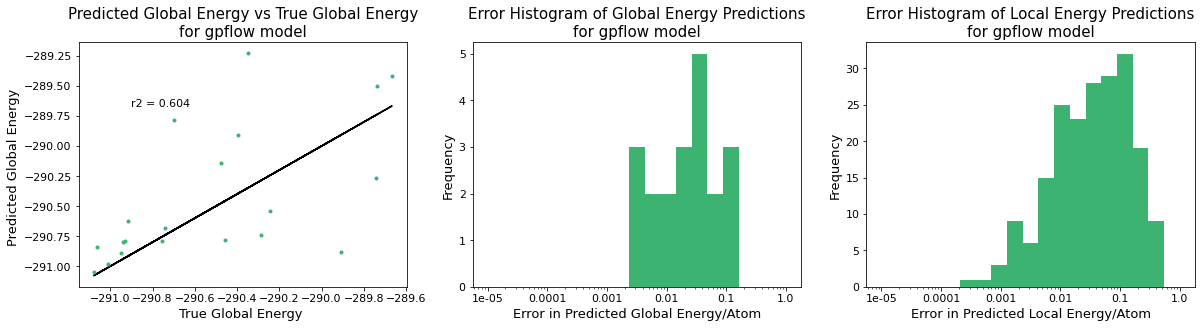

In [26]:
# make a regroup function
test_ens_regrouped = test_ens_rescaled.reshape(-1, len(StructureList[0]))
predict_ens_regrouped = predict_ens_rescaled.reshape(-1, len(StructureList[0]))
self_energies_regrouped = [[self_energy(atom.symbol, use_librascal_values=True) for atom in StructureList[i]] for i in test_indices]
test_global_ens = np.sum(test_ens_regrouped + self_energies_regrouped, axis=1)
predict_global_ens = np.sum(predict_ens_regrouped + self_energies_regrouped, axis=1)

if s.prediction_calculation == "predict_f":
    predict_ens_var_regrouped = predict_ens_var_rescaled.reshape(-1, len(StructureList[0]))
    predict_global_ens_var = np.sum(predict_ens_var_regrouped, axis=1)
    predict_global_ens_std = predict_global_ens_var ** 0.5 
    input_std = (gpr_model.likelihood.variance.numpy() * ens_scaler.scale_[0] **2) ** 0.5
    print("Our observation noise variance implies our reference error is +/- {:.3} /atom".format( input_std) )
else:
    predict_global_ens_std = None
plot_errors(model_description = "gpflow model",
            use_local=True,
            global_ens=test_global_ens,   predicted_global_ens= predict_global_ens,
            local_ens= test_ens_rescaled, predicted_local_ens = predict_ens_rescaled,
            color="mediumseagreen", predicted_stdev = None, n_atoms=n_atoms )
#plt.savefig("../media/librascal_database_local_energy_learning_gpflow_polynomial_kernel")

In [27]:
if s.use_forces:
    predict_frcs_rescaled


    fig, axs = plt.subplots(ncols=3, figsize=(20,5))
    components = ["x", "y", "z"]
    force_max = max(np.max(test_frcs_rescaled), np.max(predict_frcs_rescaled)) + np.std(test_frcs_rescaled)/2
    force_min = min(np.min(test_frcs_rescaled), np.min(predict_frcs_rescaled)) - np.std(test_frcs_rescaled)/2

    for i in range(3):

        axs[i].plot([force_min, force_max], [force_min, force_max], "-", c="k")
        axs[i].plot(test_frcs_rescaled[:,i], test_frcs_rescaled[:,i], "o", c="k", ms=4)
        axs[i].plot(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i], "o", label="custom", c="mediumseagreen", ms=5, alpha=.5)
        #axs[i].legend()
        axs[i].set_xlim(force_min, force_max); axs[i].set_ylim(force_min, force_max)

        try:
            m, b = np.polyfit(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i], 1)
            r2 = np.corrcoef(test_frcs_rescaled[:,i], predict_frcs_rescaled[:,i])[0,1]
            print("Least-squares regresion for F{}({}) produces the line line m {}+b with m = {:.5f} and b = {:.5f} which has r2 = {:.5f} ".format(components[i],components[i],components[i],m,b, r2))
        except:
            pass    

    #plt.savefig("../media/librascal_database_local_energy_force_learning")

# Save as script 

The following cell will save this notebook as a python script with today's date in the code directory 

In [1]:
import datetime as dt 
today = dt.datetime.today()
converted_notebook_path = "../code/miniGAP_from_notebook_{:02d}_{:02d}_{:d}".format(today.month, today.day, today.year)
!jupyter nbconvert --to script miniGAP_minimal.ipynb --output "{converted_notebook_path}"

[NbConvertApp] Converting notebook miniGAP_minimal.ipynb to script
[NbConvertApp] Writing 42103 bytes to ../code/miniGAP_from_notebook_11_24_2021.py
